# Spec2Vec - Search for matching compounds in a spectral library
One very important use case for a spectral similariy measure is libarary matching.  
This means matching previously unseen/unknown spectra to known, annotated sepctra in a larger library.

In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
sys.path.insert(0, ROOT)

### Import pre-processed dataset "AllPositive"

In [2]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 112956


In [2]:
# alternative (faster)
import pickle
outfile = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.pickle')
with open(outfile, 'rb') as file:
    spectrums = pickle.load(file)

Text(0, 0.5, 'number of spectra in respective bin')

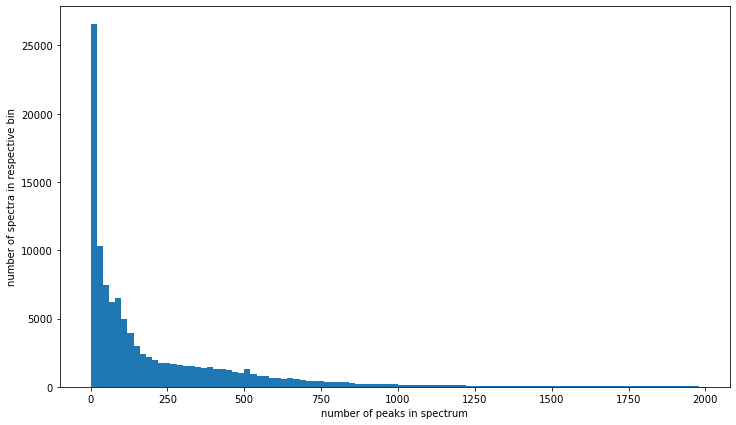

In [3]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

## Post-process data
We here do different post-processing for either the "classical" scores (Cosine, modified Cosine) or Spe2Vec. The reason for this is mostly to make sure that we do full justice to the classical similarity measures.

#### Post-processing for classical scores
Cosine and modified cosine scores are build on multiplying intensities of matching peaks. Small peaks (<0.01) hence contribute very little to the final scores and are left out to avoid excessive computation times. 
+ normalize peaks (maximum intensity to 1)
+ remove peaks outside [0, 1000] m/z window
+ remove spectra with < 10 peaks
+ remove peaks with intensities < 0.01 of maximum intensity.

#### Post-processing for Spec2Vec
Spec2Vec similarity scores rely on creating a ``document vector`` for each spectrum. For the underlying word2vec model we want the documents (=spectra) to be more homogeneous in their number of unique words. Assuming that larger compounds will on average break down into a higher number of meaningful fragment peaks we reduce the document size of each spectrum according to its parent mass.
+ normalize peaks (maximum intensity to 1)
+ remove peaks outside [0, 1000] m/z window
+ remove spectra with < 10 peaks
+ reduce number of peaks to maximum of 0.5 * parent mass
+ remove peaks with intensities < 0.001 of maximum intensity (unless this brings number of peaks to less than 10)

In [4]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process_classical(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

# apply filters to the data
spectrums_classical = [post_process_classical(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_classical = [s for s in spectrums_classical if s is not None]

print("{} remaining spectra.".format(len(spectrums_classical)))

95320 remaining spectra.


In [6]:
import pickle
pickle.dump(spectrums_classical, 
            open(os.path.join(path_data,'gnps_positive_ionmode_processed_classical.pickle'), "wb"))

In [3]:
import pickle
outfile = os.path.join(path_data,'gnps_positive_ionmode_processed_classical.pickle')
with open(outfile, 'rb') as file:
    spectrums_classical = pickle.load(file)

In [5]:
def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_s2v = [post_process_s2v(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_s2v = [s for s in spectrums_s2v if s is not None]

print("{} remaining spectra.".format(len(spectrums_s2v)))

95320 remaining spectra.


In [7]:
import pickle
pickle.dump(spectrums_s2v, 
            open(os.path.join(path_data,'gnps_positive_ionmode_processed_s2v.pickle'), "wb"))

In [2]:
import pickle
outfile = os.path.join(path_data,'gnps_positive_ionmode_processed_s2v.pickle')
with open(outfile, 'rb') as file:
    spectrums_s2v = pickle.load(file)

Text(0, 0.5, 'number of spectra in respective bin')

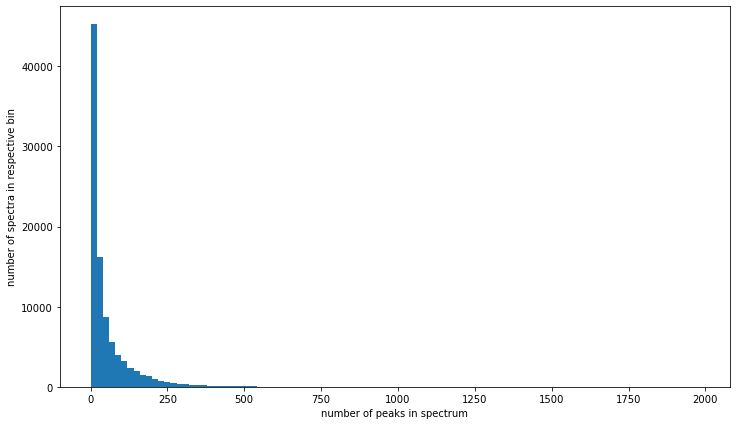

In [8]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_classical]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

In [9]:
np.max(number_of_peaks)

42049

Text(0, 0.5, 'number of spectra in respective bin')

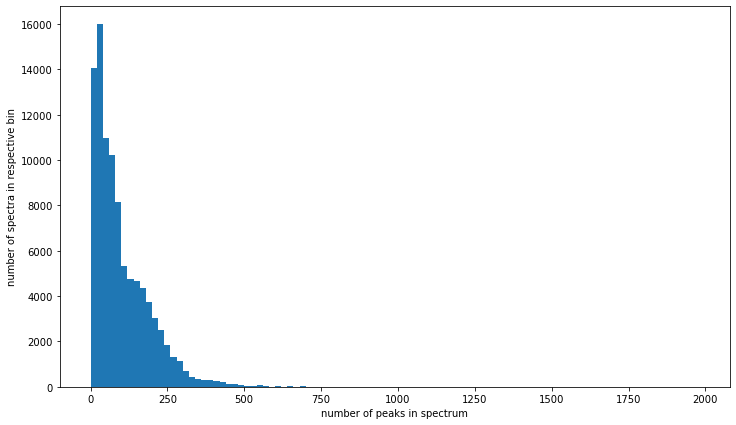

In [10]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_s2v]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

In [11]:
np.max(number_of_peaks)

1081

## Inspect annotations

In [4]:
Inchikeys = []
for spec in spectrums_classical:
    Inchikeys.append(spec.get("inchikey"))

In [5]:
Inchikeys[:10]

['IYDKWWDUBYWQGF-NNAZGLEUSA-N',
 'KNGPFNUOXXLKCN-ZNCJFREWSA-N',
 'WXDBUBIFYCCNLE-NSCMQRKRSA-N',
 'CGZKSPLDUIRCIO-RPCRKUJJSA-N',
 '',
 'USXIYWCPCGVOKF-LERJCCFDSA-N',
 '',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N',
 'USXIYWCPCGVOKF-NOENWEJRSA-N',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N']

In [14]:
Inchikeys[:10]

['IYDKWWDUBYWQGF-NNAZGLEUSA-N',
 'KNGPFNUOXXLKCN-ZNCJFREWSA-N',
 'WXDBUBIFYCCNLE-NSCMQRKRSA-N',
 'CGZKSPLDUIRCIO-RPCRKUJJSA-N',
 '',
 'USXIYWCPCGVOKF-LERJCCFDSA-N',
 '',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N',
 'USXIYWCPCGVOKF-NOENWEJRSA-N',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N']

In [6]:
inchikeys_pd = pd.Series([x for x in Inchikeys if x])
inchikeys_pd.str[:14].value_counts()[:30]

NEGQHKSYEYVFTD    432
SULIDBRAXVDKBU    426
IQGPMZRCLCCXAG    308
WTJKGGKOPKCXLL    295
IIZPXYDJLKNOIY    235
RWKUXQNLWDTSLO    234
QIBZFHLFHCIUOT    225
ZAYXPDDGEIJGGW    212
QJWDAOSZZYVBJZ    210
KILNVBDSWZSGLL    205
RFVFQQWKPSOBED    202
IESVDEZGAHUQJU    197
LFUDDCMNKWEORN    195
JLPULHDHAOZNQI    182
LSOWKZULVQWMLY    180
XGGMHQYOVYWRLV    178
LLHISNQVRRYJGL    175
JFISYPWOVQNHLS    174
SRIGHEHXEGELQJ    166
ACTIUHUUMQJHFO    163
PZNPLUBHRSSFHT    162
YLWSJLLZUHSIEA    158
GPWHCUUIQMGELX    150
BLZVZPYMHLXLHG    148
QEDPUVGSSDPBMD    146
IGZPHNNYPPAPLA    142
CITHEXJVPOWHKC    141
SXNXGNVZTLZDHE    131
YEJYLHKQOBOSCP    131
AXZGUCXCTZMPTR    128
dtype: int64

Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

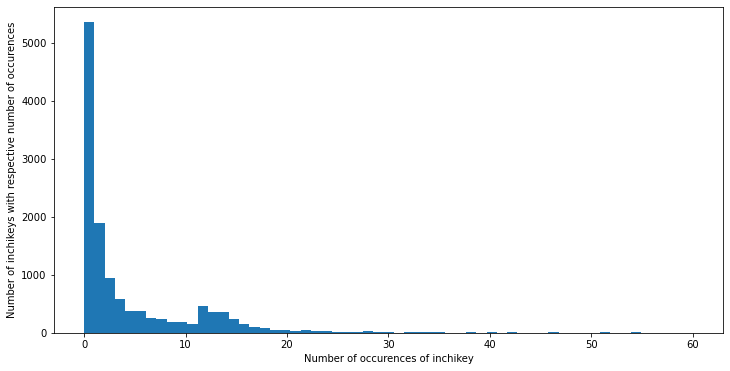

In [16]:
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14].value_counts(), np.linspace(0, 60, 60))
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

## Select query test set
Pick 1500 spectra such that:
- 500 spectra have > 1 matching Inchikeys in the library
- 500 spectra have = 1 matching Inchikey in the library
- 500 spectra have = 0 matching Inchikey in the library

In [88]:
import operator
relate = operator.eq
value = 1
test = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[relate(inchikeys_pd.str[:14].value_counts().values, value)])

In [114]:
suitable_inchikeys[suitable_inchikeys["inchikey14"] == ""]

,inchikey14,occurences
0,,18226


In [115]:
import operator
np.random.seed(42) # to make it reproducible
num_spectra = 500
selected_query_inchikeys = []

for relate, value in [(operator.eq, 1), (operator.eq, 2), (operator.ge, 3)]:
    suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[relate(inchikeys_pd.str[:14].value_counts().values, value)])
    print(f"Found {suitable_inchikeys.shape[0]} Inchikey with num of copies {relate.__name__} {value} \n")
    suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
    suitable_inchikeys.columns = (['inchikey14', 'occurences'])
    suitable_inchikeys = suitable_inchikeys[~suitable_inchikeys['inchikey14'].isin([""])]  # remove spectra w/o inchikey
    print("Resulting table starts with:")
    print(suitable_inchikeys.head())  
    print()
    selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
    selected_query_inchikeys.append(suitable_inchikeys['inchikey14'].values[selection])

Found 5352 Inchikey with num of copies eq 1 

Resulting table starts with:
       inchikey14  occurences
0  RMACBBOFZDWABJ           1
1  DZUXGQBLFALXCR           1
2  JDIGWVAMJGGRBY           1
3  YWAXVDLXUXRDHL           1
4  XIVYFPUTCCJWCJ           1

Found 1896 Inchikey with num of copies eq 2 

Resulting table starts with:
       inchikey14  occurences
0  LDDHMLJTFXJGPI           2
1  GYTJPFXYRURXOG           2
2  ZWIVVTOKXTZAOT           2
3  FPNYZEUDIBOJQA           2
4  ZUPASDOWHXCIHQ           2

Found 5599 Inchikey with num of copies ge 3 

Resulting table starts with:
       inchikey14  occurences
1  NEGQHKSYEYVFTD         432
2  SULIDBRAXVDKBU         426
3  IQGPMZRCLCCXAG         308
4  WTJKGGKOPKCXLL         295
5  IIZPXYDJLKNOIY         235



In [116]:
len(selected_query_inchikeys[0]), len(selected_query_inchikeys[1]), len(selected_query_inchikeys[2])

(500, 500, 500)

In [119]:
selected_query_all = list(selected_query_inchikeys[0]) +\
                     list(selected_query_inchikeys[1]) +\
                     list(selected_query_inchikeys[2])
len(selected_query_all)

1500

In [210]:
selected_query_all[:10]

['YSSBJODGIYRAMI',
 'ZIXQOZABHRGIPJ',
 'USOIUYXBYYVLLZ',
 'GQNUDXCKVPLQBI',
 'SVKLZVIIPWYADX',
 'YMGXBGVMAOTRFZ',
 'KIVVSHRPMQEJCD',
 'MBRGVPJSDHLXNJ',
 'QATUWZPYBIHFFR',
 'VEZJYLMJOIHBAD']

### Inspect number of library spectra with same InChIKey as queries

In [214]:
inchikeys14_array = np.array([x[:14] for x in Inchikeys if x is not None])
number_of_copies = []

for inchikey in selected_query_all:
    number_of_copies.append(len(np.where(inchikeys14_array == inchikey)[0]))

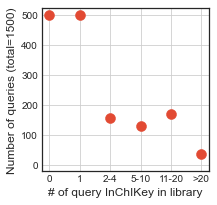

In [268]:
plt.figure(figsize=(3,3))
plt.style.use('seaborn-white')
bins = [0, 1.5, 2.5, 5.5, 11.5, 21.5, 101.5]
labels = ["0", "1", "2-4", "5-10", "11-20", ">20"]
a, b = np.histogram(number_of_copies, bins)
plt.scatter(labels, a, s=100)
#plt.hist(number_of_copies, [0,1.01,2.01,100]) #np.linspace(0, 60, 60))
plt.ylabel('Number of queries (total=1500)')
plt.xlabel('# of query InChIKey in library')
plt.ylim(-20)
plt.grid(True)
plt.savefig("library_matching_scenario3_library_condition.svg")

### Randomly pick one spectra for each of the chosen inchikeys

In [121]:
selected_spectra = []
inchikeys_pd = pd.Series([x for x in Inchikeys]) #include all even empty ones to get the IDs right!

np.random.seed(42) # to make it reproducible
for inchikey in selected_query_all:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.append(int(np.random.choice(matches,1)[0]))

In [122]:
selected_spectra[:10]

[17475, 19360, 58794, 11739, 19358, 16961, 8838, 3403, 1127, 8478]

In [123]:
# Show gnps IDs for selected spectra
for ID in selected_spectra[:10]:
    print(spectrums_s2v[ID].get("spectrumid"),
          spectrums_s2v[ID].get("inchikey")[:14])

CCMSLIB00000085398 YSSBJODGIYRAMI
CCMSLIB00004722036 ZIXQOZABHRGIPJ
CCMSLIB00000205497 USOIUYXBYYVLLZ
CCMSLIB00000848650 GQNUDXCKVPLQBI
CCMSLIB00004722034 SVKLZVIIPWYADX
CCMSLIB00000084884 YMGXBGVMAOTRFZ
CCMSLIB00000080039 KIVVSHRPMQEJCD
CCMSLIB00004722215 MBRGVPJSDHLXNJ
CCMSLIB00000078861 QATUWZPYBIHFFR
CCMSLIB00000079677 VEZJYLMJOIHBAD


## Train new model on AllPositive dataset WITHOUT selected spectra

In [124]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

In [125]:
documents_library_s2v = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_s2v) if i not in selected_spectra]

In [126]:
documents_library_classical = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_classical) if i not in selected_spectra]

In [127]:
len(documents_library_s2v), len(spectrums_s2v)  # 1500 should be removed

(93820, 95320)

In [128]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_librarymatching_known_unknown_201126.model")

iterations = [1, 3, 5, 10, 15, 20]

# Train model with default parameters
model = train_new_word2vec_model(documents_library_s2v, iterations, model_file)

  Epoch 1 of 20.Change in loss after epoch 1: 5778416.5
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_librarymatching_known_unknown_201126_iter_1.model
  Epoch 2 of 20.Change in loss after epoch 2: 4254766.5
  Epoch 3 of 20.Change in loss after epoch 3: 3690748.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_librarymatching_known_unknown_201126_iter_3.model
  Epoch 4 of 20.Change in loss after epoch 4: 3509431.0
  Epoch 5 of 20.Change in loss after epoch 5: 2864992.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_librarymatching_known_unknown_201126_iter_5.model
  Epoch 6 of 20.Change in loss after epoch 6: 2757812.0
  Epoch 7 of 20.Change in loss after epoch 7: 2663832.0
  Epoch 8 of 20.Change in loss after epoch 8: 2582584.0
  Epoch 9 of 20

## Actual library matching

In [129]:
sys.path.insert(0, os.path.join(ROOT, "custom_functions"))

In [130]:
from library_search import library_matching

#### Load word2vec model

In [131]:
path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_librarymatching_known_unknown_201126_iter_15.model")
model = gensim.models.Word2Vec.load(model_file)

In [132]:
documents_query_s2v = [SpectrumDocument(spectrums_s2v[i], n_decimals=2) for i in selected_spectra]

In [133]:
documents_query_classical = [SpectrumDocument(spectrums_classical[i], n_decimals=2) for i in selected_spectra]

In [134]:
len(documents_query_s2v)

1500

In [135]:
documents_query_s2v[0]._obj.get("inchikey")

'YSSBJODGIYRAMI-UHFFFAOYSA-N'

### Correct a few (< 10) spectrums with missing precursor_mz

In [136]:
for i, spec in enumerate(spectrums_classical):
    if not spec.get("precursor_mz"):
        print(i)
        fix_mass = 0.0
        for history in spec.metadata['annotation_history']:
            fix_mass_test = float(history['Precursor_MZ'])
            fix_mass = max(fix_mass, fix_mass_test)
        charge = spec.get("charge")
        protons_mass = 1.00727645199076 * charge
        precursor_mass = fix_mass * abs(charge)
        parent_mass = precursor_mass - protons_mass
        if parent_mass:
            print("parent mass new:", parent_mass, "former was:", spec.get("parent_mass"))
            spec.set("parent_mass", parent_mass)
        print("precursor_mz new:", fix_mass, "former was:", spec.get("precursor_mz"))
        spec.set("precursor_mz", fix_mass)

In [137]:
for i, spec in enumerate(spectrums_s2v):
    if not spec.get("precursor_mz"):
        print(i)
        fix_mass = 0.0
        for history in spec.metadata['annotation_history']:
            fix_mass_test = float(history['Precursor_MZ'])
            fix_mass = max(fix_mass, fix_mass_test)
        charge = spec.get("charge")
        protons_mass = 1.00727645199076 * charge
        precursor_mass = fix_mass * abs(charge)
        parent_mass = precursor_mass - protons_mass
        if parent_mass:
            print("parent mass new:", parent_mass, "former was:", spec.get("parent_mass"))
            spec.set("parent_mass", parent_mass)
        print("precursor_mz new:", fix_mass, "former was:", spec.get("precursor_mz"))
        spec.set("precursor_mz", fix_mass)

### Run Spec2Vec and parentmass based library matching for 1500 against 93820 spectra
- precursor m/z tolerance: 1 ppm

# Compare to 1ppm precursor m/z tolerance (instead of 2 above)

In [189]:
found_matches_s2v = library_matching(documents_query_s2v, documents_library_s2v,
                                     model,
                                     presearch_based_on=["precursor_mz", "spec2vec-top20"],
                                     ignore_non_annotated=True,
                                     intensity_weighting_power=0.5,
                                     allowed_missing_percentage=10.0,
                                     cosine_tol=0.005,
                                     mass_tolerance=1.0,
                                     mass_tolerance_type="ppm")

  0%|                                                                              | 1/75602 [00:00<2:07:29,  9.88it/s]

Pre-selection includes spec2vec top 20.


 25%|███████████████████▊                                                          | 380/1500 [00:01<00:03, 359.11it/s]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.49%.


 38%|█████████████████████████████▋                                                | 571/1500 [00:01<00:02, 362.83it/s]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.


 55%|███████████████████████████████████████████▎                                  | 832/1500 [00:02<00:01, 435.40it/s]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.02%.


 75%|█████████████████████████████████████████████████████████▌                   | 1122/1500 [00:02<00:00, 534.31it/s]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.85%.


 91%|█████████████████████████████████████████████████████████████████████▉       | 1363/1500 [00:03<00:00, 568.00it/s]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.92%.


100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:03<00:00, 436.14it/s]


Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.86%.
Pre-selection includes mass matches within 1.0 ppm.
Calculate cosine score for selected candidates.
Calculate modified cosine score for selected candidates.


In [190]:
found_matches_classical = library_matching(documents_query_classical, documents_library_classical,
                                           model,
                                           presearch_based_on=["precursor_mz"],
                                           include_scores=["cosine", "modcosine"],
                                           ignore_non_annotated=True,
                                           intensity_weighting_power=0.5,
                                           allowed_missing_percentage=50.0,
                                           cosine_tol=0.005,
                                           mass_tolerance=1.0,
                                           mass_tolerance_type="ppm")

Pre-selection includes mass matches within 1.0 ppm.
Calculate cosine score for selected candidates.
Calculate modified cosine score for selected candidates.


## Evaluate different similarity score thresholds

In [191]:
min_match = 2
cosine_thresholds = np.arange(0, 1, 0.05)

test_matches_min2 = []
for threshold in cosine_thresholds:
    print(f"Checking matches for cosine score > {threshold:.2f}")
    test_matches = []
    
    for ID in range(len(documents_query_classical)):
        if len(found_matches_classical[ID]) > 0:
            # Scenario 1: mass + sort by cosine
            df_select = found_matches_classical[ID][(found_matches_classical[ID]['mass_match'] == 1)
                                         & (found_matches_classical[ID]['cosine_score'] > threshold)
                                         & (found_matches_classical[ID]['cosine_matches'] >= min_match)]

            if df_select.shape[0] > 0:
                best_match_ID = df_select.sort_values(by=['cosine_score'], ascending=False).index[0]
                inchikey_selected = documents_library_classical[best_match_ID]._obj.get("inchikey")[:14]
                inchikey_query = documents_query_classical[ID]._obj.get("inchikey")[:14]

                best_bet = 1 * (inchikey_selected == inchikey_query)
            else:
                best_bet = -1 # meaning: not found
            test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)

    test_matches_min2.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for cosine score > 0.00
Checking matches for cosine score > 0.05
Checking matches for cosine score > 0.10
Checking matches for cosine score > 0.15
Checking matches for cosine score > 0.20
Checking matches for cosine score > 0.25
Checking matches for cosine score > 0.30
Checking matches for cosine score > 0.35
Checking matches for cosine score > 0.40
Checking matches for cosine score > 0.45
Checking matches for cosine score > 0.50
Checking matches for cosine score > 0.55
Checking matches for cosine score > 0.60
Checking matches for cosine score > 0.65
Checking matches for cosine score > 0.70
Checking matches for cosine score > 0.75
Checking matches for cosine score > 0.80
Checking matches for cosine score > 0.85
Checking matches for cosine score > 0.90
Checking matches for cosine score > 0.95


Text(0, 0.5, 'true positives')

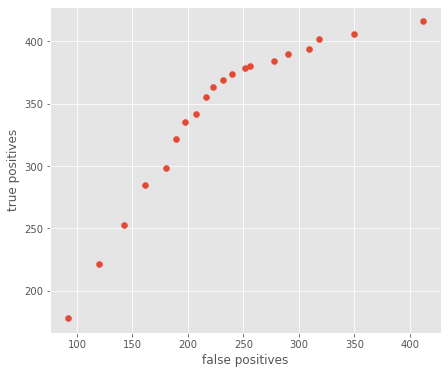

In [192]:
test_matches_arr = np.array(test_matches_min2)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.scatter(test_matches_arr[:,1], test_matches_arr[:,0])
plt.xlabel('false positives')
plt.ylabel('true positives')

In [193]:
min_match = 6
cosine_thresholds = np.arange(0, 1, 0.05)

test_matches_min6 = []
for threshold in cosine_thresholds:
    print(f"Checking matches for cosine score > {threshold:.2f}")
    test_matches = []
    
    for ID in range(len(documents_query_classical)):
        if len(found_matches_classical[ID]) > 0:
            # Scenario 1: mass + sort by cosine
            df_select = found_matches_classical[ID][(found_matches_classical[ID]['mass_match'] == 1)
                                             & (found_matches_classical[ID]['cosine_score'] > threshold)
                                             & (found_matches_classical[ID]['cosine_matches'] >= min_match)]

            if df_select.shape[0] > 0:
                best_match_ID = df_select.sort_values(by=['cosine_score'], ascending=False).index[0]
                inchikey_selected = documents_library_classical[best_match_ID]._obj.get("inchikey")[:14]
                inchikey_query = documents_query_classical[ID]._obj.get("inchikey")[:14]

                best_bet = 1 * (inchikey_selected == inchikey_query)
            else:
                best_bet = -1 # meaning: not found
            test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)
    
    test_matches_min6.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for cosine score > 0.00
Checking matches for cosine score > 0.05
Checking matches for cosine score > 0.10
Checking matches for cosine score > 0.15
Checking matches for cosine score > 0.20
Checking matches for cosine score > 0.25
Checking matches for cosine score > 0.30
Checking matches for cosine score > 0.35
Checking matches for cosine score > 0.40
Checking matches for cosine score > 0.45
Checking matches for cosine score > 0.50
Checking matches for cosine score > 0.55
Checking matches for cosine score > 0.60
Checking matches for cosine score > 0.65
Checking matches for cosine score > 0.70
Checking matches for cosine score > 0.75
Checking matches for cosine score > 0.80
Checking matches for cosine score > 0.85
Checking matches for cosine score > 0.90
Checking matches for cosine score > 0.95


Text(0, 0.5, 'true positives')

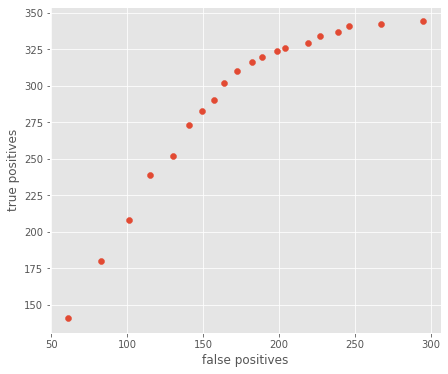

In [194]:
test_matches_arr = np.array(test_matches_min6)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.scatter(test_matches_arr[:,1], test_matches_arr[:,0])
plt.xlabel('false positives')
plt.ylabel('true positives')

In [195]:
test_matches_s2v = []

cosine_thresholds = np.arange(0,1,0.05)

for threshold in cosine_thresholds:
    print(f"Checking matches for spec2vec score > {threshold:.2f}")
    test_matches = []
    
    for ID in range(len(documents_query_s2v)):

        # Scenario 2: mass + sort by Spec2Vec
        df_select = found_matches_s2v[ID][(found_matches_s2v[ID]['mass_match'] == 1)
                                      & (found_matches_s2v[ID]['s2v_score'] > threshold)]
        if df_select.shape[0] > 0:
            best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
            inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
            inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
            
            best_bet = 1 * (inchikey_selected == inchikey_query)
        else:
            best_bet = -1 # meaning: not found
        test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)
    
    test_matches_s2v.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for spec2vec score > 0.00
Checking matches for spec2vec score > 0.05
Checking matches for spec2vec score > 0.10
Checking matches for spec2vec score > 0.15
Checking matches for spec2vec score > 0.20
Checking matches for spec2vec score > 0.25
Checking matches for spec2vec score > 0.30
Checking matches for spec2vec score > 0.35
Checking matches for spec2vec score > 0.40
Checking matches for spec2vec score > 0.45
Checking matches for spec2vec score > 0.50
Checking matches for spec2vec score > 0.55
Checking matches for spec2vec score > 0.60
Checking matches for spec2vec score > 0.65
Checking matches for spec2vec score > 0.70
Checking matches for spec2vec score > 0.75
Checking matches for spec2vec score > 0.80
Checking matches for spec2vec score > 0.85
Checking matches for spec2vec score > 0.90
Checking matches for spec2vec score > 0.95


Text(0, 0.5, 'true positives')

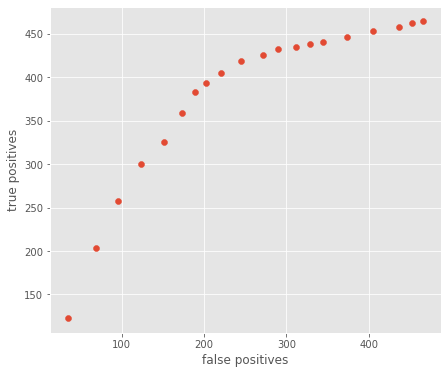

In [196]:
test_matches_s2v_arr = np.array(test_matches_s2v)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.scatter(test_matches_s2v_arr[:,1], test_matches_s2v_arr[:,0])
plt.xlabel('false positives')
plt.ylabel('true positives')

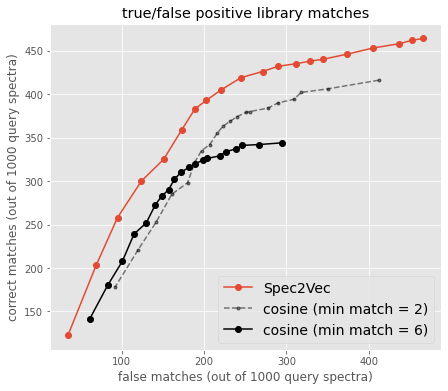

In [197]:
test_matches_min2_arr = np.array(test_matches_min2)
test_matches_min6_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.plot(test_matches_s2v_arr[:,1], test_matches_s2v_arr[:,0], 
         'o-', label='Spec2Vec')
plt.plot(test_matches_min2_arr[:,1], test_matches_min2_arr[:,0], 
         '.--', color='black', alpha=0.5, label='cosine (min match = 2)')
plt.plot(test_matches_min6_arr[:,1], test_matches_min6_arr[:,0], 
         'o-', color='black', label='cosine (min match = 6)')
plt.title('true/false positive library matches')
plt.legend(fontsize=14)
plt.xlabel('false matches (out of 1000 query spectra)')
plt.ylabel('correct matches (out of 1000 query spectra)')
plt.savefig('library_matching_knowns_and_unknowns_201127_1ppm.pdf')

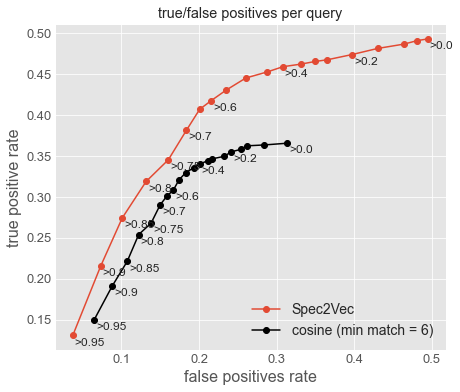

In [265]:
min_match = 6
#test_matches_cosine_arr = np.array(test_matches_ROC_min2)
test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,12,14,15,16,17,18,19]

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
num_max = np.sum(test_matches_arr[0,:])

plt.plot(test_matches_s2v_arr[:,1]/num_max, test_matches_s2v_arr[:,0]/num_max, 
         'o-', label='Spec2Vec')
plt.plot(test_matches_cosine_arr[:,1]/num_max, test_matches_cosine_arr[:,0]/num_max, 
         'o-', color='black', label='cosine (min match = {})'.format(min_match))
for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_s2v_arr[i,1]/num_max, test_matches_s2v_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10), fontsize=12)
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_cosine_arr[i,1]/num_max, test_matches_cosine_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10), fontsize=12)

plt.title('true/false positives per query')
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('false positives rate', fontsize=16)
plt.ylabel('true positive rate', fontsize=16)
#plt.xlim([0, 0.3])
plt.savefig('library_matching_true-false_knowns_and_unknowns_201127_1ppm.pdf')

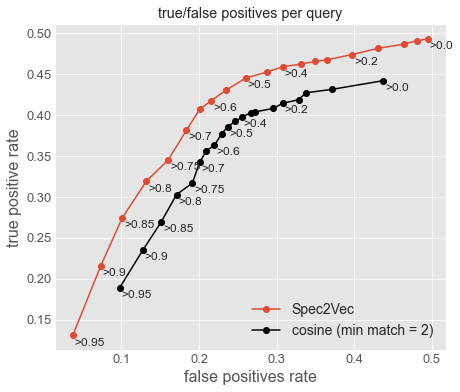

In [264]:
min_match = 2
test_matches_cosine_arr = np.array(test_matches_min2)
#test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,10,12,14,15,16,17,18,19]

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
num_max = np.sum(test_matches_arr[0,:])

plt.plot(test_matches_s2v_arr[:,1]/num_max, test_matches_s2v_arr[:,0]/num_max, 
         'o-', label='Spec2Vec')
plt.plot(test_matches_cosine_arr[:,1]/num_max, test_matches_cosine_arr[:,0]/num_max, 
         'o-', color='black', label='cosine (min match = {})'.format(min_match))
for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_s2v_arr[i,1]/num_max, test_matches_s2v_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10), fontsize=12)
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_cosine_arr[i,1]/num_max, test_matches_cosine_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10), fontsize=12)

plt.title('true/false positives per query')
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('false positives rate', fontsize=16)
plt.ylabel('true positive rate', fontsize=16)
#plt.xlim([0, 0.3])
plt.savefig('library_matching_true-false_knowns_and_unknowns_minmatch_2_201127_1ppm.pdf')

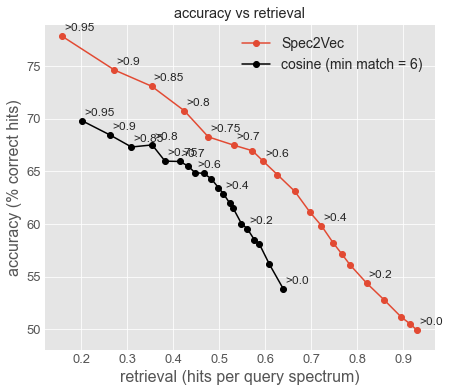

In [263]:
min_match=6
#test_matches_cosine_arr = np.array(test_matches_min2)
test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,12,14,15,16,17,18,19]

accuracy_s2v = 100 * test_matches_s2v_arr[:,0]/(test_matches_s2v_arr[:,0] + test_matches_s2v_arr[:,1])
accuracy_cosine = 100 * test_matches_cosine_arr[:,0]/(test_matches_cosine_arr[:,0] + test_matches_cosine_arr[:,1])

retrieval_s2v = (test_matches_s2v_arr[:,1] + test_matches_s2v_arr[:,0])/1000
retrieval_cosine = (test_matches_cosine_arr[:,1] + test_matches_cosine_arr[:,0])/1000

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.plot(retrieval_s2v, accuracy_s2v, 'o-', label='Spec2Vec')
plt.plot(retrieval_cosine, accuracy_cosine, 'o-', color="black", label='cosine (min match = {})'.format(min_match))

for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_s2v[i], accuracy_s2v[i]),
                    textcoords="offset points", xytext=(2, 5), fontsize=12)
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_cosine[i], accuracy_cosine[i]),
                    textcoords="offset points", xytext=(2, 5), fontsize=12)

plt.title('accuracy vs retrieval')
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim([48, 79])
plt.xlabel('retrieval (hits per query spectrum)', fontsize=16)
plt.ylabel('accuracy (% correct hits)', fontsize=16)
plt.savefig('library_matching_accuracy_vs_retrieval_knowns_and_unknowns_201127_1ppm.pdf')

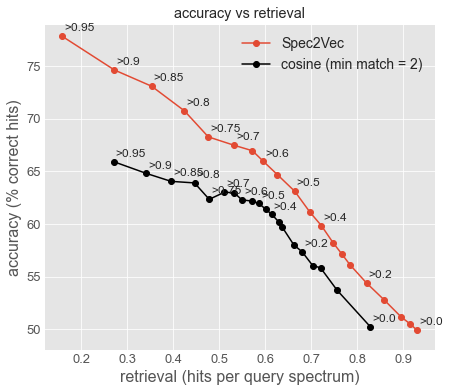

In [262]:
min_match=2
test_matches_cosine_arr = np.array(test_matches_min2)
#test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,10,12,14,15,16,17,18,19]

accuracy_s2v = 100 * test_matches_s2v_arr[:,0]/(test_matches_s2v_arr[:,0] + test_matches_s2v_arr[:,1])
accuracy_cosine = 100 * test_matches_cosine_arr[:,0]/(test_matches_cosine_arr[:,0] + test_matches_cosine_arr[:,1])

retrieval_s2v = (test_matches_s2v_arr[:,1] + test_matches_s2v_arr[:,0])/1000
retrieval_cosine = (test_matches_cosine_arr[:,1] + test_matches_cosine_arr[:,0])/1000

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.plot(retrieval_s2v, accuracy_s2v, 'o-', label='Spec2Vec')
plt.plot(retrieval_cosine, accuracy_cosine, 'o-', color="black", label='cosine (min match = {})'.format(min_match))

for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_s2v[i], accuracy_s2v[i]),
                    textcoords="offset points", xytext=(2, 5), fontsize=12)
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_cosine[i], accuracy_cosine[i]),
                    textcoords="offset points", xytext=(2, 5), fontsize=12)

plt.title('accuracy vs retrieval')
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim([48, 79])
plt.xlabel('retrieval (hits per query spectrum)', fontsize=16)
plt.ylabel('accuracy (% correct hits)', fontsize=16)
plt.savefig('library_matching_accuracy_vs_retrieval_minmatch2_knowns_and_unknowns_201127_1ppm.svg')